## Note that there will be some obvious redundancy in the notebook wrt the code, but this is done just so that there's a good flow of how things are working and you can understand everything well 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

**xs is just a range of values**

In [4]:
xs = np.arange(-5, 5, 0.25) 
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

**Now we just add the function f(x) to all the values of xs**

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

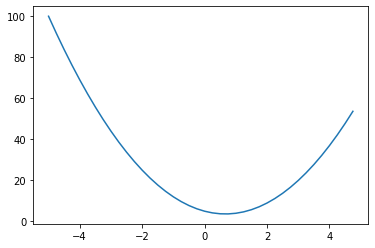

In [6]:
plt.plot(xs, ys)

**Now lets get into derivatives**

In [7]:
h = 0.00000001
x = 3.0
f(x) #we see that f(x) is now 20

20.0

In [8]:
f(x+h) #now when we add a small value, given that x is +ve, f(x+h) will now be slightly greater than 20

20.00000014

In [9]:
#By how much did the function respond? In this case in the +ve direction... It is given by,
f(x+h) - f(x)

1.400000009255109e-07

In [10]:
(f(x+h) - f(x))/h #We look at how much x would change when we add the small value 'h' and normalise it by dividing it by 'h',
#which essentially gives us the slope and this is what derivatives are all about.

#Through derivates we essentially try to observe by how much a particular function responeded and normalise it to get the slope.

#The slope essentially tells us the strength of that change

14.00000009255109

In [11]:
#Now what happens if we take x = -3.0
h = 0.00000001
x = -3.0
(f(x+h) - f(x))/h

#Now if we add a slight +ve value to a -ve number then the slope would go down

-22.00000039920269

**Let's make it complex**

In [12]:
h = 0.001

a = 2.0
b= -3.0
c = 10.0

d1 = a*b + c
a+=h #Since we are increasing a, this would make the product (a*b) bigger and hence the fucntion responds by slightly decreasing
#in value --> slope = -ve
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h) # (f(x+h)-f(x))/h

#again the slope over here is simply like deriving the function wrt 'a' in this case. We can do the same wrt 'b' and 'c' if
#we increase either 'b' or 'c' by 'h'

d1 4.0
d2 3.997
slope -3.0000000000001137


# Start of Micrograd

### data = value stored
### children = values that make up a given expression
### _op = the operator
### label = just helps us visualise better in the diagram
### grad = gradient or slope
### _backward = function that will automate the chain rule of differntiation, which is essentially what backprop is all about

In [13]:
#BEST WAY TO UNDERSTAND THIS CLASS IS BY COMING BACK TO THIS PART OCCASIONALLY AS YOU READ THROUGH THE REST OF THE NOTEBOOK
#THERE ARE PROMPTS AHEAD IN THE NOTEBOOK WHICH WILL LEAD YOU BACK TO THIS CLASS EVERY NOW AND THEN

class Value:
    #children basically stores the values making up a given expression
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.grad = 0.0
        self.label=label

#repr is a python functionality basically returns data in a human friendly manner instead of throwing some arbitrary text  
    def __repr__(self):
        return f"Value(data={self.data})" 

#defining the addition function
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other) # TO make sure something like a + 1 works
        out = Value(self.data + other.data, (self, other), '+')#so self and other over here are the values which make up one addition operation
        
        #basically doing the backprop right after forward propagation, i.e, calculate the resultant node using the current
        #nodes which is now essentially the parent node in backprop mechanism and through this parent node
        #we will calculate the gradients of the children node backwards
        #(READ THIS AGAIN SLOWLY, IT WILL MAKE SENSE)
        def _backward():
            self.grad += 1.0 * out.grad #i.e, (local gradient)*(parent node's gradient)
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self+other
    
    
    def __mul__(self, other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') #similar to the _children in add
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self*other

#defiining the tanh activation function
    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad # (1 - tanh(x)**2) * 1 --> 1 because the derivative of o wrt o is obviously 1
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) #Only supporting int and float for now
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad #derivative (x^n) = n.x^(n-1)... * out.grad to maintain 
            #chain rule
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    #The idea here being a/b = a*(1/b) = a*b**-1
    
    def __neg__(self): #Negation function that will be used for subtraction
        return self*-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def backward(self):
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
# a = Value(2.0)
# b = Value(-3.0)
# c= Value(10.0)

# a,b,c

In [14]:
a+b # a.__add__(b) ; a acts like self here basically

-0.9990000000000001

In [15]:
a*b #a.__mul__(b)

-6.003

In [16]:
a*b + c # (a.__mul__(b)).__add__(c)

3.997

In [17]:
(a.__mul__(b)).__add__(c) #this works too

3.997

In [18]:
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c= Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

In [19]:
d._prev #gives the values of 'a*b' and 'c' which make up the whole expression d = a*b + c

{Value(data=-6.0), Value(data=10.0)}

In [20]:
d._op

'+'

## Now let's visualise the expression

In [21]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data%.4f | grad%.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            #if this value is a result of some operation , create an _op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

### Visual representation of the whole expression
### Example 1 - Backprop for a simple expression

So what we see now is the forward propogation of the expression for 'L'. What we are interested in is the backpropogation where we check the derivative of 'L' with each and every node in the backward direction, i.e, (dL/df), (dL/dd), (dL/de) and so on...

In NN's some nodes act as weights which keep getting updated upon each backprop iteration. We usually don't look into the derivative of L wrt the data nodes 'a' and 'b', since they are constants.

Think of 'L' as the loss function and we keep checking its derivate wrt prev nodes (weights) iteratively,using the gradient(slope), until we reach a minimum loss function.

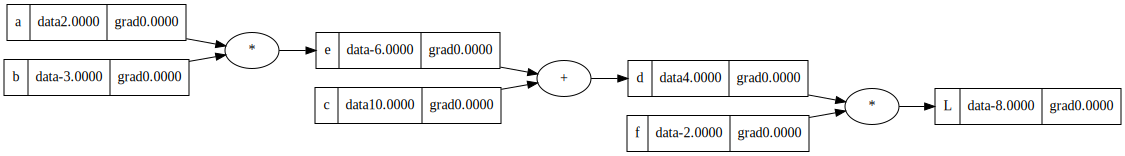

In [22]:
draw_dot(L)

#### Ok so let's start calculating the slopes now.

1. First consider derivative of L wrt L, wkt it is 1.0 (because dL/dL = 1)

2. Now let's check derivative of L wrt d
    1. dL/dd = d[(d*f)]/dd = f = -2.0
    2. Therfore gradient of d = -2.0
    
3. Similarly, gradient of f = d = 4.0

In [23]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0

#### Now lets calculate for c and e

We gotta apply the chain rule here

1. L wrt c
    1. dL/dc = (d[d*f])/dc = (d[(a*b + c)*f])/dc = (d[abf + cf])/dc = f = -2.0

2. Similarly,
    1. dL/de = (d[d*f])/de = (d[(e + c)*f])/de = (d[ef + cf])/de = f = -2.0
    
So with the '+' operation, the gradient is (local gradient) x (the prev grad) = 1.0 * the prev grad.

So what the '+' essentially does is that it simply distibutes the grad of the current node to its children.....
In our case 'd' distributes its gradient to c and e

In [24]:
c.grad = -2.0
e.grad = -2.0

In [25]:
#Similarly we keep applying the chain rule till we backprop to the very last node left and get the values as assigned below

a.grad = 6.0 #dL/da = 6.0
b.grad = -4.0 #dL/db

Ulitmately this is what backprop is all about, you keep multiplying the local derivatives till the leaf nodes.

Now we'll try to increase the value of L by nudging the child nodes, and we nudge them in the direction of their respective gradients.

In our case, the value of L is -8.0, so the value of L should become less negative

In [26]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

#We'll observe that the value of L becomes less -ve now and it keeps on increasing on each iteration.This is key for NNs
L

Value(data=-7.286496)

### Example 2 - Manual backprop of a neuron

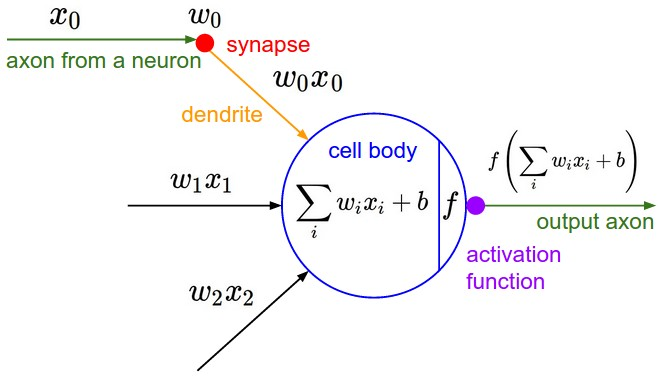

#### Now consider this representation of the neuron...

1. Here, inputs are axons (x) and the synapes (w) are all weights.

<br>

2. The synapses interact with the inputs multiplicatively which together form the dendrites (wx)

<br>

3. Now each neuron has multiple inputs hence multiple such dendrites

<br>

4. All the dendrites add up to form the cell body where we have a bias, 'b'. The bias is sort of like the innate trigger happines of the neuron and it could make the neuron more trigger happy or less trigger happy irrespective of the inputs

<br>

5. Now, we take the contents of this cell body and pass it through an activation function. The activation function is usually like a squashing function which basically puts a cap on extreme values. tanh is an example of one activation function

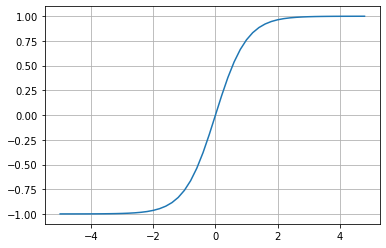

In [27]:
#Example of tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

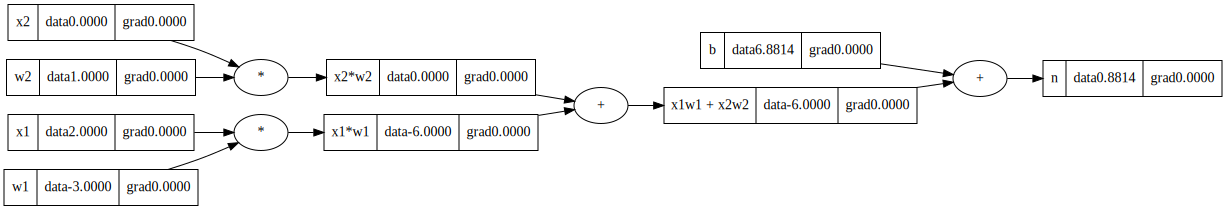

In [28]:
#inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137335870194532, label='b') #We are choosing this number purely so that we have nicer, comprehensible number

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

draw_dot(n)

#### Now let's introduce the tanh activation function to get the output from this neuron

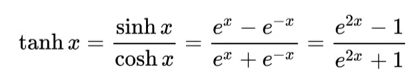

Looking at the equation of tanh, we realise that we can't implement tanh merely using addition and multiplication, hence we need to define a custom 'tanh()' function within the main class such that it has exponentiation as well as division"

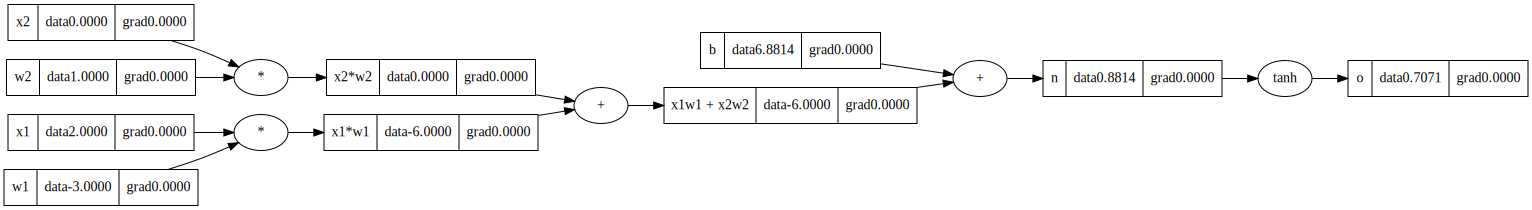

In [29]:
o = n.tanh(); o.label='o'
draw_dot(o)

#### Now we get to differentiating backwards through this neuron which is essentially backprop in NNs

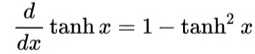

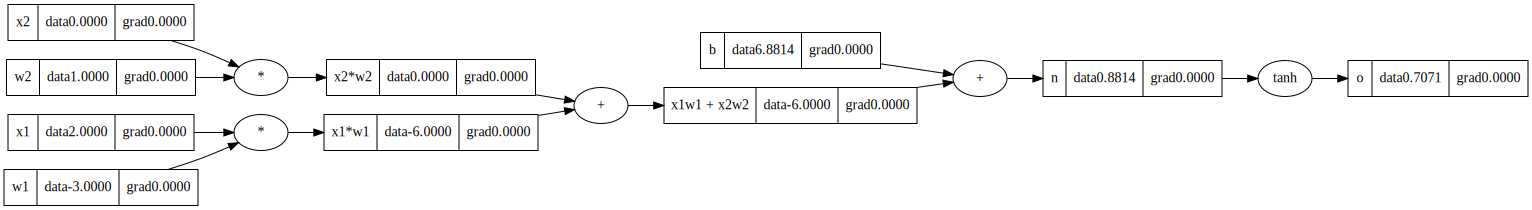

In [30]:
draw_dot(o)

In [31]:
#firstly, grad of o
o.grad = 1.0

Now we check do/dn

o=tanh(n)

Therefore, do/dn = d(tanh(n))/dn 
                = 1-tanh(n)^2 
                = 1 - o^2 
                = 1-o.data^2

In [32]:
n.grad = 1 - o.data**2
n.grad

0.5000001614449345

In [33]:
#now for x1w1+x2w2 and b we can see that there is a plus operator, and from the first example wkt that gradient just gets distributed
#from the node 'n' to its children x1w1+x2w2 and b ,i.e

x1w1x2w2.grad = 1 * n.grad #because local derivative of child nodes after '+' operator is one and that's why grad just gets 'distributed'
b.grad = 1*n.grad

In [34]:
#same case as before with x1w1 and x2w2 due to '+' operator

In [35]:
x1w1.grad = 1*x1w1x2w2.grad
x2w2.grad = 1*x1w1x2w2.grad

In [36]:
#Now let's get to the leaf nodes and here we are most interested with the weights w1 and w2 since that is what we adjust
#to minimize the loss function as much as possible

#here we observe the multiplication operator and from the first example this is how the calculation of the gradients go...

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad, w1.grad, x2.grad, w2.grad

(-1.5000004843348036, 1.000000322889869, 0.5000001614449345, 0.0)

### Now go back to the class definition to see how this backprop process is automated and then we'll look at how the automation works

In [37]:

#inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137335870194532, label='b') #We are choosing this number purely so that we have nicer, comprehensible number

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

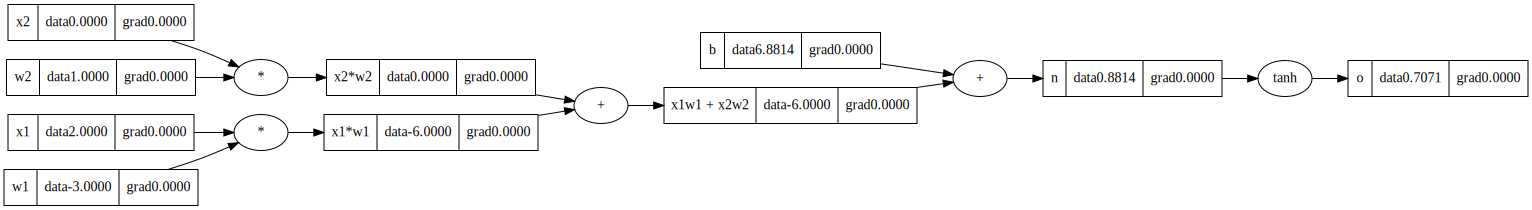

In [38]:
draw_dot(o)

### #Uncomment and Run the next four cells if you want to check the step by step backprop implementation at each node#

In [39]:
#Remember that grad is initially set to 0 by default, hence as a base case we must set o.grad=1, otherwise we won't see any
#change in grads throughout the neuron
# o.grad=1.0

In [40]:
# o._backward() #n.grad should now be 0.5 after you redraw the neuron

In [41]:
# n._backward()

In [42]:
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

Although this is impressive, we really don't want to manually call the backprop function manually for each and every node. We need to automate this process.

1. First we will look into something called topological sort:
    1. The jist here is that we really don't want to call the backprop on any node until the complete forward propagation is complete, i.e. we need to get the output of the neuron first and only then will we start backprop.
    
    2. Topological sort basically sorts all the nodes in the right order, such that all edges of the graph only move from left to right which helps in a smooth backprop till the leaf nodes.
    
    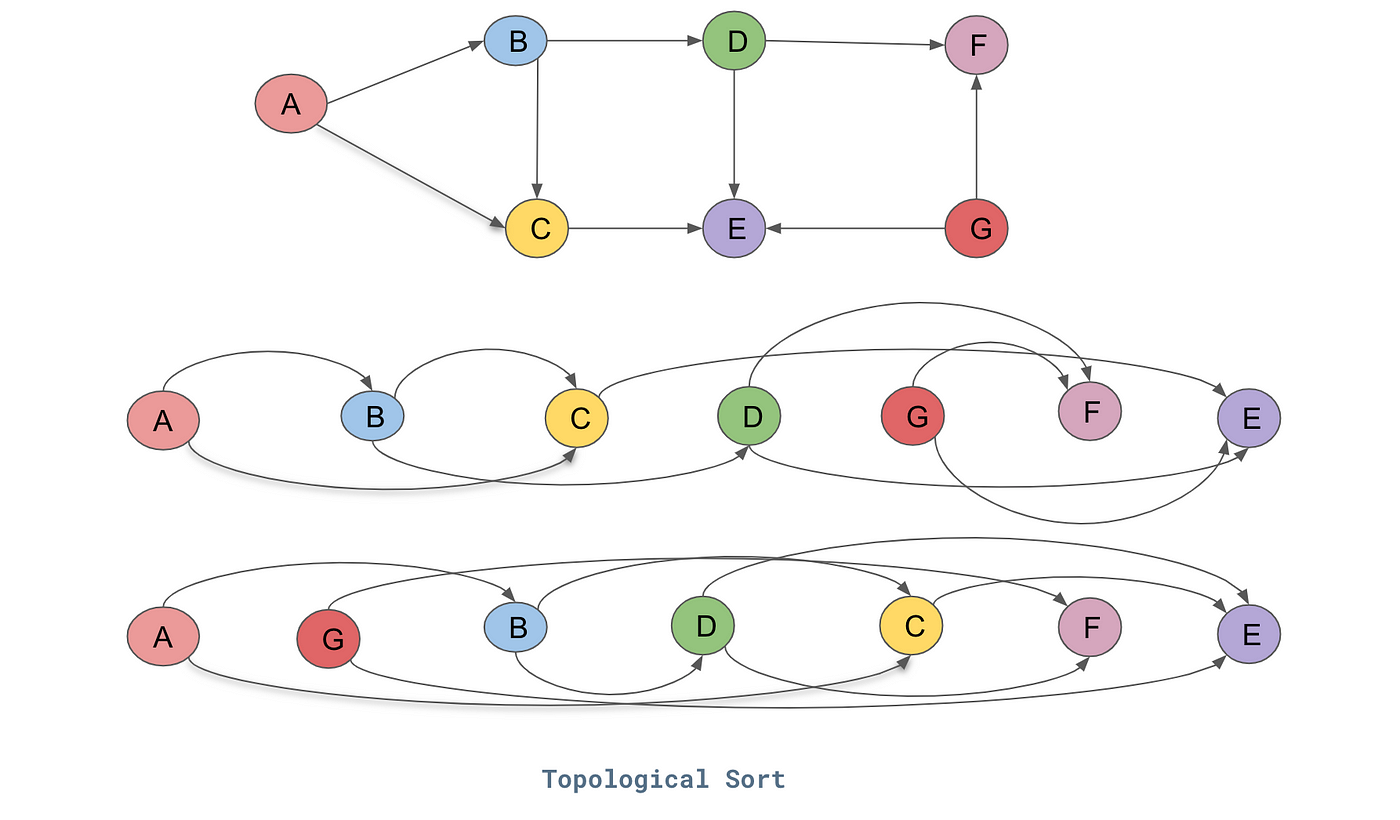
    
#### 2. After this please go back to the main class to take a look at the definition of the completely automated backprop function

In [43]:
#Implementation of topological sort --> This is enclosed in the main class for a cleaner implementation
#Uncomment the next 3 cells if you want to see them in action, just gives you a broken down explanation of the whole automation

# topo = []
# visited = set()

# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)

# build_topo(o)
# topo

[Value(data=6.881373358701945),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813733587019454),
 Value(data=0.7071066670277303)]

The topo list is as follows:

##### first path - o->n->x1w1x2w2->x1w1->x1->w1
<br>

#### second path - .......       ->x2w2->x2->w2
<br>

#### third path - o->n->b     

In [44]:
#To ensure that the whole backprop runs smoothly, we reverse the topologically sorted list and then start the backprop
#from the output node

# for node in reversed(topo):
#     node._backward()

In [45]:
#draw_dot(o) #We will now see that just by running node._backward we could get the whole graph or neuron in one shot

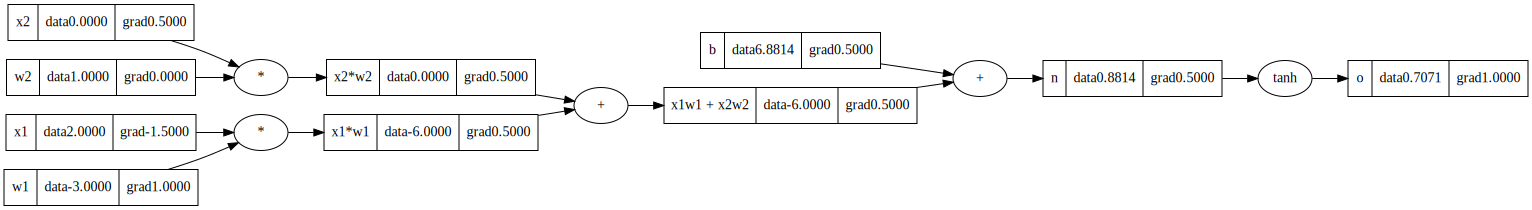

In [46]:
#Now that we have defined the whole backprop function in the main class let's see it in action
o.backward()
draw_dot(o)


### But we now have a bug that has rather gone unnoticed!
The following examples will make the bug obvious

#### Example 1

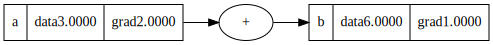

In [47]:
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

Now what we can see here is that the gradient of a is wrong

1. b = 2a
<br>

2. db/da = d[2a]/da = 2
<br>

But we see that a.grad = db/da = 1, which is clearly wrong

#### Example 2

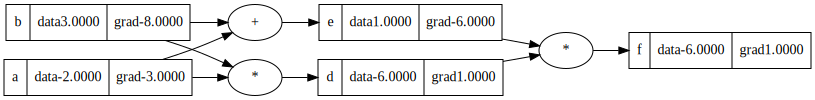

In [48]:
a = Value(-2.0, label='a')
b= Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

Again, here the gradients of 'a' and 'b' are wrong

What's happening is that the gradient values are getting replaced.

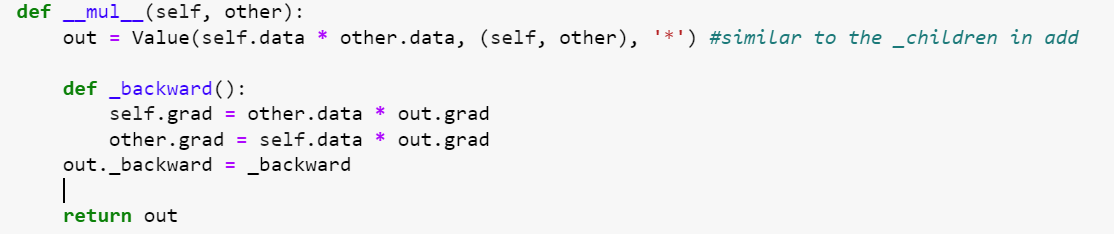

If we take a look at this multiplication function definition within the main class, we observe that if we were to use the same variable more than once, because of the way the gradient update is defined, the repeated variable's gradient value gets replaced as and when it is repeated.

The solution is to simply accumalate(or add) the gradient values instead of assigning them, i.e
1. Instead of self.grad = other.data * out.grad
2. We make it self.grad += other.data * out.grad

#### This simple change in the main class in both the add and mul functions will fix the bug. You can always revert back to the unchanged gradient update in the main class if you want to see the bug again

## Breaking up tanh into its elements

We need to look into a few things before we get to breaking up tanh.

Firstly, with the operations, we can't do something like a+1, because 1 is treated as 'other' in the add function, which is supposed be a Value object, but clearly 1 isn't a Value object.
So, we will define 'other' in the classes __add__ and __mul__ such that it will wrap any integers into a Value object

In [49]:
a+1 #a.__add__(1)

Value(data=-1.0)

In [50]:
a*2 #a.__mul__(2)

Value(data=-4.0)

Now although this seems right, it isn't cos we can't do something like
<br>
2*a
<br>
#### To resolve this we will define an __rmul_ class in the main class.
<br>
What function does is that it takes an operation like 2*a, and since 2 can't multiply a, it will check if a can multiply 2 and perform that function ,i.e
<br>
instead of 2.__mul__(a), it will peroform
<br>
a.__mul__(2)
<br>

So it's basically a callback

In [51]:
2*a 

Value(data=-4.0)

With that out of the way we can get back to the tanh function. So from the defn. of tanh we still need to be able to exponentiate and divide, so let's define those functions as well in the Value class. At the same time we will define the division and subtraction functions as well.

In [52]:
#inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137335870194532, label='b') #We are choosing this number purely so that we have nicer, comprehensible number

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

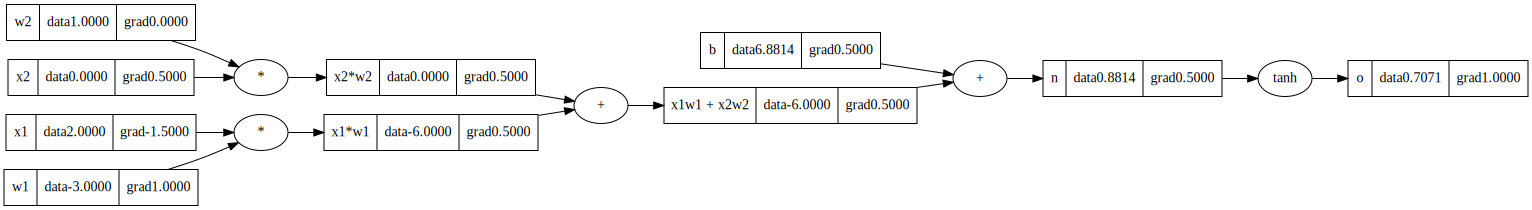

In [53]:
draw_dot(o)

In [54]:
#Now let's break down that tanh activation function into the tanh expanded expression
#inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137335870194532, label='b') #We are choosing this number purely so that we have nicer, comprehensible number

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'
#------
e = (2*n).exp()
o = (e-1)/(e+1)
#------
o.label='o'
o.backward()


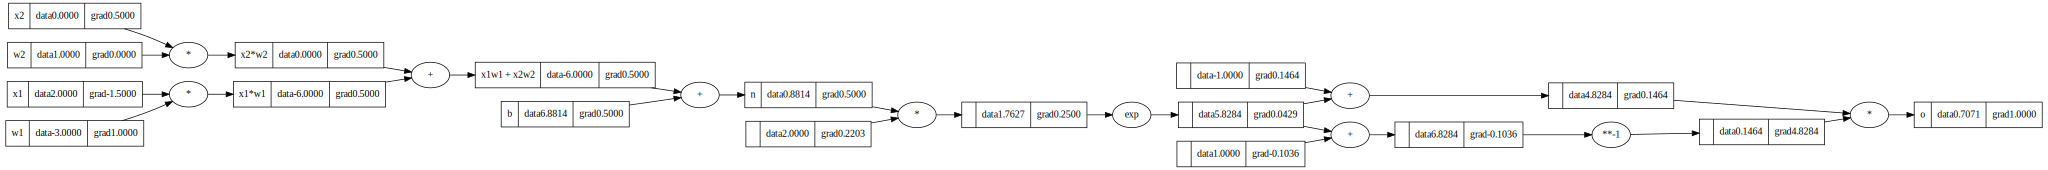

In [55]:
draw_dot(o)

## Pytorch implementation of the same

In [56]:
import torch

In [57]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad=True
b = torch.Tensor([6.8814]).double() ; b.requires_grad=True

#Since these are leaf nodes, we have to explicitly mention that they requrire gradients as pytorch disables it for efficiency
#purposes

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.item())
o.backward()
print('xxxxxxxxxxxxxxxxx')

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071200415967962
xxxxxxxxxxxxxxxxx
x2 0.49998124677214517
w2 0.0
x1 -1.4999437403164355
w1 0.9999624935442903


# Building a NN library (Multi-Layer Perceptron)

With all of that done, let's start building a Neural Net library
<br>
1. We will first create a _single layer_ Neuron which takes multiple inputs and gives an output based on that

2. Next we will build a _Multi-Layer Perceptron_ which has multiple neuron layers and looks something like this

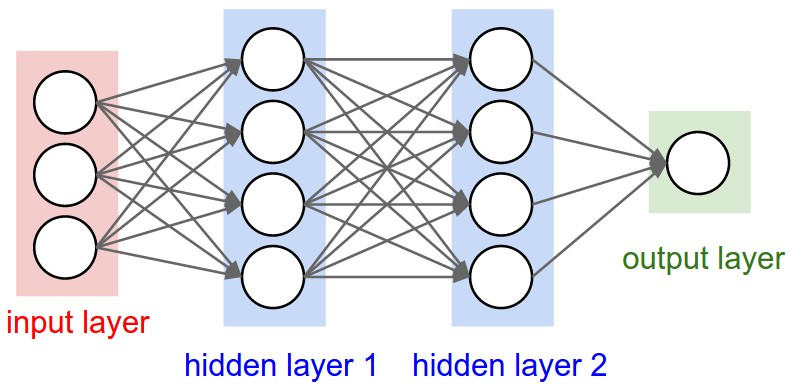

In [58]:
import random

In [59]:
class Neuron:
    
    def __init__(self, num_inputs): # num_inputs = total Number of inputs that the neuron will have
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)] #create weights for each input
        self.b = Value(random.uniform(-1,1)) #bias
        
    def __call__(self, x):
        # w*x + b -> w*x is a DOT PRODUCT
        # So if we create a Neuron with some values and call Neuron(x), this function is called and it will give us an output
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b #So we basically create the values that are in the cell body,
        #which will be passed through an activation function
        out = act.tanh()
        
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    
    def __init__(self, num_inputs, num_output):
        #takes the number of inputs and number of output as parameters and then creates num_outputs number of neurons in a 
        #given layer
        self.neurons = [Neuron(num_inputs) for _ in range(num_output)]
        
    def __call__(self, x):
        
        #evaluate the outputs of each and every neuron in a given layer
        outs = []
        for neuron in self.neurons:
            outs.append(neuron(x))
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        #returns the weights and biases of each and every neruon in the layer
        return [p for neuron in self.neurons for p in neuron.parameters()] 
    
class MLP:
    
    def __init__(self, num_inputs, num_outputs):
    #takes the number of inputs as usual and takes a list of num_outputs such that it can create multiple layers with different
    #number of neurons
        sz = [num_inputs] + num_outputs #input=3 and output=[4,4,1] --> [3] + [4,4,1] = [3,4,4,1]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs))]# 1st iteration -> Layer(3,4); 2nd-->Layer(4,4)...& so on
    
    def __call__(self, x):
        #call each layer sequentially
        #This function calls for the evaluation of each layer--> Layer class calls for the evaluation of each neuron in each layer
        #--> Neruon class calculates the output for each and every neuron and hence the values of all neurons are calculated
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        #returns the weights and biases of every single neuron in every single layer
        return [p for layer in self.layers for p in layer.parameters()] 
    


In [60]:
x = [2.0, 3.0]
n= Neuron(2) # Create a neruon with 2 inputs
n(x)

Value(data=0.9995159583468769)

In [61]:
x = [2.0, 3.0]
n= Layer(2, 3) # Create a layer with 2 inputs and 
n(x)

[Value(data=-0.6609203560647444),
 Value(data=0.8300639274060337),
 Value(data=-0.9856803408360432)]

In [62]:
x = [2.0, 3.0, -1.0]
n= MLP(3, [4,4,1]) # Recreating the MLP diagram shown above with 3 inputs, two 4 neuron layers and one output neuron
n(x)

Value(data=-0.5074918853389881)

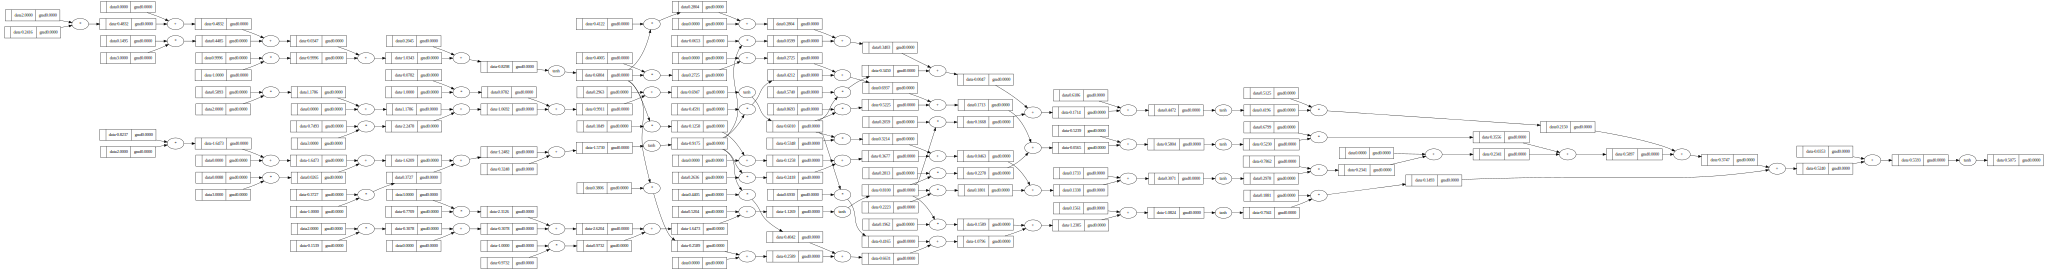

In [63]:
draw_dot(n(x))

## Let's create our own dataset now and try to check the performance of our model

In [64]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets, i.e for each of the inputs, we want the following outputs respectively
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5074918853389881),
 Value(data=0.9017729272596422),
 Value(data=0.37734253440765253),
 Value(data=0.7056951791103152)]

#### Lets now look into the loss function

From the values above we can see that for a given input, its output still isn't equal to the desired values. Therefore, we will now define a loss function which will basically help the NN train better.


In [65]:
#So we want to look at the difference between the target values and values predicted by the MLP NN, i.e ys-ypred
#We will implement the mean square error

[(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]#ygt = ground truth value

[Value(data=2.272531784362897),
 Value(data=3.6167402668577084),
 Value(data=1.8970724570884951),
 Value(data=0.08661532759890944)]

In [66]:
#We can see that we get individual losses for each input, we want to aggregate this

loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.872959835908011)

#### And now we want to minimise this loss. The lower this loss value, the lower the individual losses.

In [67]:
loss.backward()

In [68]:
n.layers[0].neurons[0].w[0] # We can now see the individual weights of each and every neuron in the MLP NN

Value(data=-0.24161830829548214)

In [69]:
n.layers[0].neurons[0].w[1].grad #each weight has a grad the moment we ran the _loss.backward()_ function.
#And as we learnt before, if we nudge these values in the direction of the gradient, it will maximise the output.
#But here our output is the loss, which we want to minimise, hence we would have to nudge the values of all the weights
#and biases in the opposite direction of the gradient in order to decrease the loss

1.3084639592570813

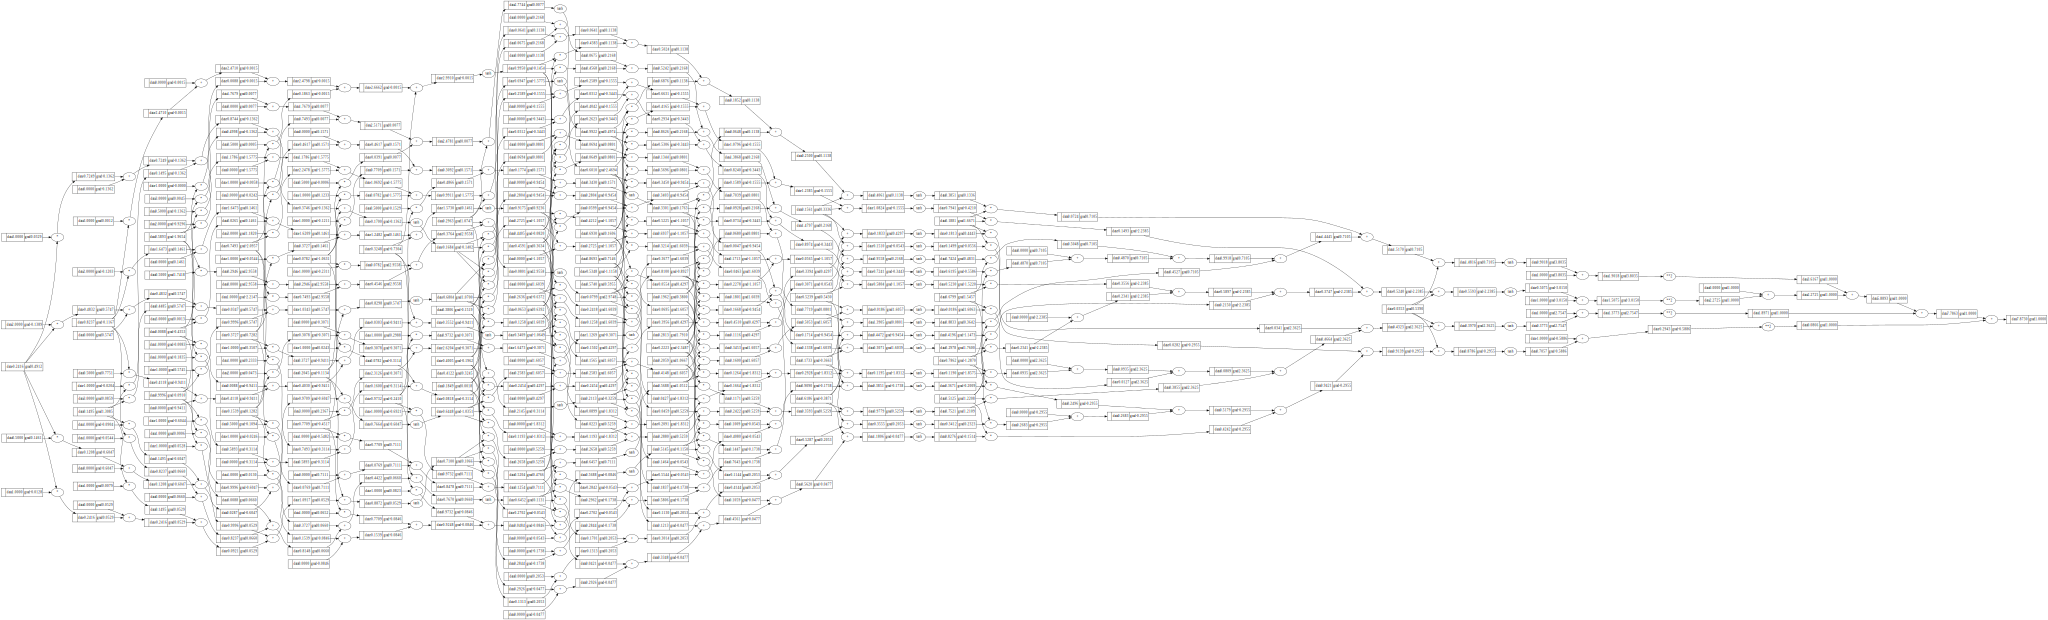

In [70]:
draw_dot(loss)

Now get back to the Neuron class to look into the implementation of the fucntion where we collect all the necessary parameters of the Neural Net, basically weights and bias, because we want to make channges to these ultimately

In [212]:
x = [2.0, 3.0, -1.0]
n= MLP(3, [4,4,1]) # Recreating the MLP diagram shown above with 3 inputs, two 4 neuron layers and one output neuron
n(x)

Value(data=-0.5332978818741538)

In [213]:
#n.parameters() #Returns the weights and biases of every single neuron present in the MLP Neural Network

In [252]:
for k in range(20):
    
    #forward pass
    ypred=[n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad=0.0 #This is necessary for each step so that the gradients don't add up to a huge number and give us bigger
        #steps. For a simple problem like the one we saw it will work without this as well, but with complex problems
        #it will be a major bug
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05*p.grad # step size * gradient --> Basically gradient descent

    print(k, loss.data)


0 0.0022035709781322264
1 0.0021993802259837217
2 0.0021952042595746266
3 0.002191043003145917
4 0.00218689638144663
5 0.002182764319729715
6 0.0021786467437477845
7 0.0021745435797490354
8 0.0021704547544732105
9 0.0021663801951474363
10 0.00216231982948233
11 0.002158273585667955
12 0.0021542413923699424
13 0.002150223178725627
14 0.002146218874340078
15 0.002142228409282423
16 0.0021382517140819896
17 0.002134288719724605
18 0.0021303393576488643
19 0.0021264035597424722


In [253]:
ypred

[Value(data=0.9950392915574298),
 Value(data=-0.9740089578984075),
 Value(data=-0.977858613688627),
 Value(data=0.9694055613848844)]